# Convolution + LSTM Temperature prediction - many to one problem





## Data

In [3]:
%tensorflow_version 2.x
%load_ext tensorboard
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
tf.random.set_seed(13)

TensorFlow 2.x selected.


In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

13574144/13568290 [==============================] - 1s 0us/step


Date Time  p (mbar)  T (degC)  ...  wv (m/s)  max. wv (m/s)  wd (deg)
0  01.01.2009 00:10:00    996.52     -8.02  ...      1.03           1.75     152.3
1  01.01.2009 00:20:00    996.57     -8.41  ...      0.72           1.50     136.1
2  01.01.2009 00:30:00    996.53     -8.51  ...      0.19           0.63     171.6
3  01.01.2009 00:40:00    996.51     -8.31  ...      0.34           0.50     198.0
4  01.01.2009 00:50:00    996.51     -8.27  ...      0.32           0.63     214.3

[5 rows x 15 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb52a909eb8>,
      dtype=object)

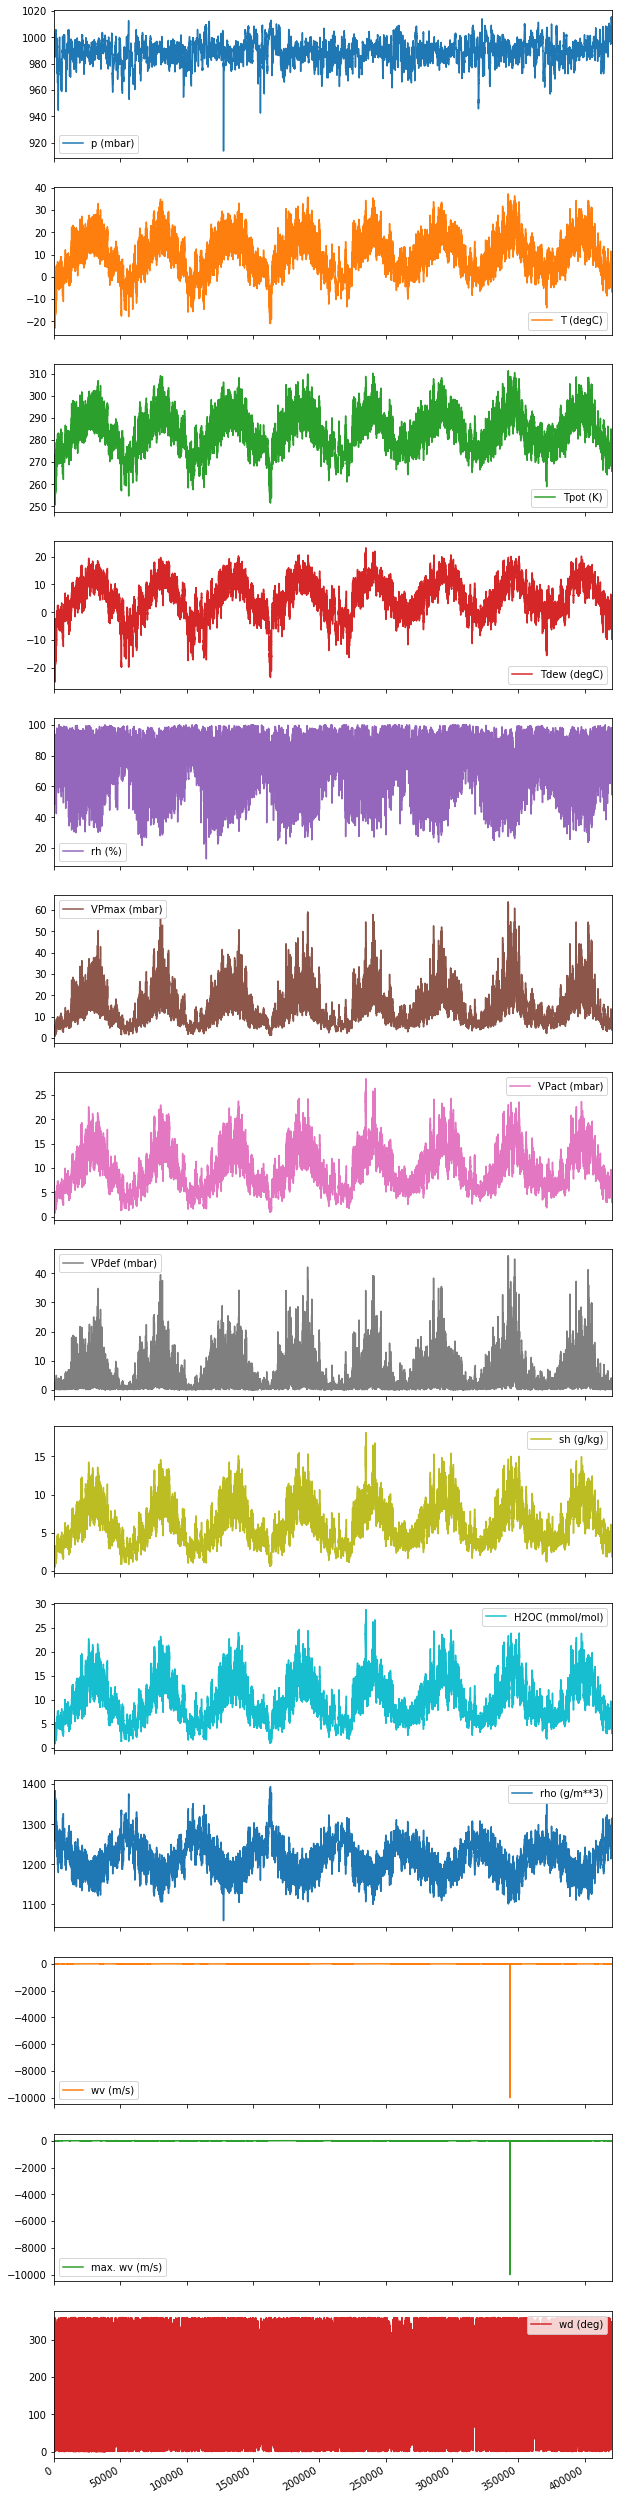

In [5]:
df.plot(subplots=True, figsize=(10,50))

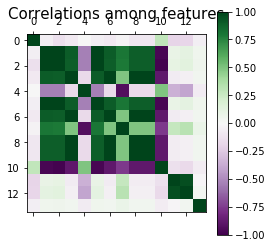

In [6]:
# Correlations among features
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('Correlations among features', size=15)
plt.colorbar()
plt.show()

In [8]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb528290b00>,
      dtype=object)

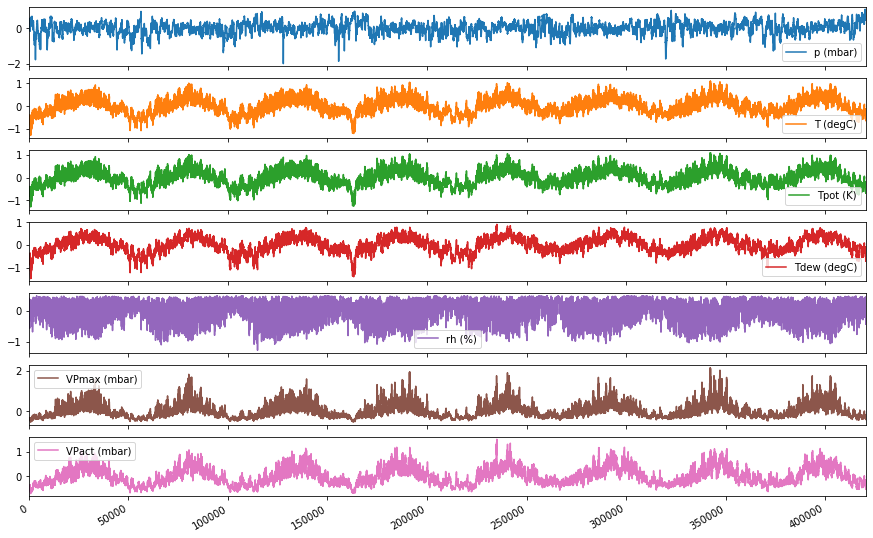

In [9]:
# 4-7, 1-10, 2-10, 3-10, 5-10, 6-10
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features_considered = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)']

data = df[features_considered]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = data_scaled/3.0
data_scaled[:,0] = [ -2.0 if data_scaled[i,0]<-2.0 else data_scaled[i,0] for i in range(0, len(data_scaled[:,0]))]
date_time = np.expand_dims(np.asarray(df['Date Time'].values), axis=1)
df_scaled = pd.DataFrame(data=data_scaled, columns=features_considered)
df_scaled.plot(subplots=True, figsize=(15,10))

Hours:  70091 
Days:  2920 
Weeks:  417 
Years:  8


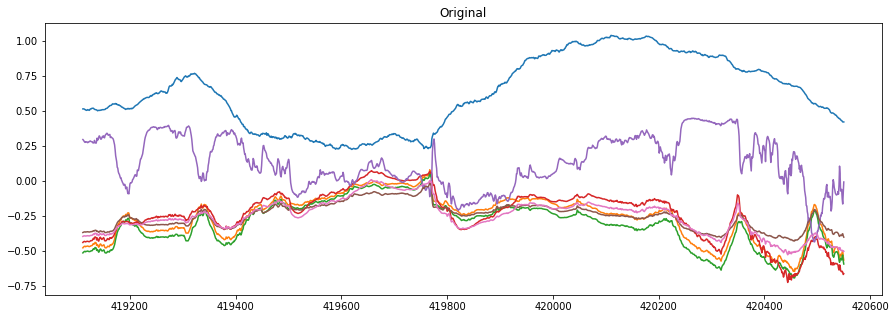

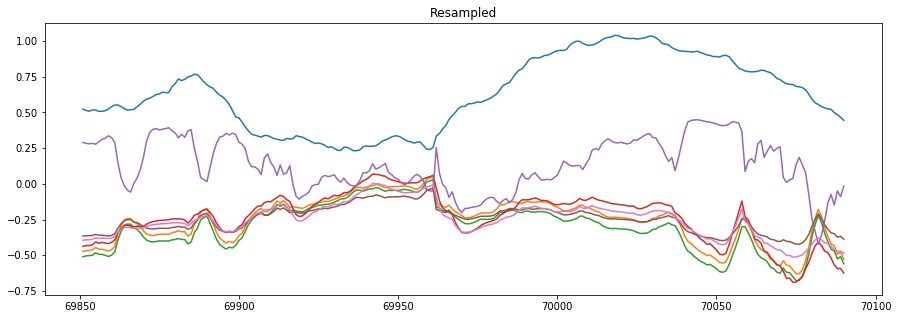

In [10]:
def resample(data, sample_rate):
  output_data = []
  for feature_index in range(0, data.shape[1]): #For every feature
    resampled_data = []
    for sample_index in range(sample_rate, len(data[:,feature_index]), sample_rate): # For every sample
      resampled_data.append(np.mean(data[sample_index-sample_rate:sample_index,feature_index]))
    output_data.append(resampled_data)
  
  return np.transpose(np.asarray(output_data))

resampled_data = resample(data_scaled, 6)
df_resampled_data = pd.DataFrame(data=resampled_data, columns=features_considered)
fig = plt.figure(figsize=(15,5))
plt.plot(df_scaled.tail(1440))
plt.title('Original')
fig = plt.figure(figsize=(15,5))
plt.plot(df_resampled_data.tail(240))
plt.title('Resampled')

data_length = resampled_data[:,0].shape[0]
print('Hours: ', data_length, '\nDays: ', int(data_length/24), '\nWeeks: ', int(data_length/24/7), '\nYears: ', int(data_length/24/365))

## Data pipeline

![alt text](https://raw.githubusercontent.com/KrzysztofV/colab-lstm-temperature-prediction/master/data.png)

In [11]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step):
  """
  Creates dataset using sliding window method.
  dataset: input data
  target: output data
  start_index, end_index: for dividing dataset
  history_size: training data size
  target_size: forecasting data size
  step: spacing between windows
  """
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index, step):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    indices = range(i, i+target_size)
    labels.append(target[indices])

  return np.array(data), np.array(labels)

past_history = 24*10
step = 24
future_target = 24
split_index = 62000

x_train, y_train = multivariate_data(resampled_data, resampled_data[:, 1], 0, split_index, past_history, future_target, step)
x_val, y_val = multivariate_data(resampled_data, resampled_data[:, 1], split_index, None, past_history, future_target, step)

# Data pipeline
batch_size = 30
encoder_input_data = x_train
decoder_input_data = y_train
decoder_target_data = np.expand_dims(y_train, axis=-1)
train_data = tf.data.Dataset.from_tensor_slices((x_train, np.expand_dims(y_train, axis=-1)))
train_data = train_data.cache().batch(batch_size).shuffle(1000).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val, np.expand_dims(y_val, axis=-1)))
val_data = val_data.batch(batch_size).repeat()

print('Number of train batches: ', int(x_train.shape[0]/batch_size))
print('Number of validation batches: ', int(x_val.shape[0]/batch_size))
print('Sum of input data [hours] in one batch: ', step*batch_size+past_history)

Number of train batches:  85
Number of validation batches:  10
Sum of input data [hours] in one batch:  960


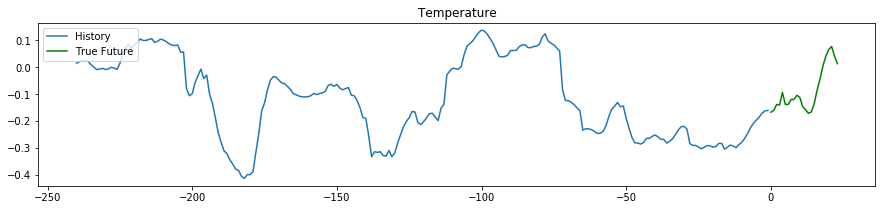

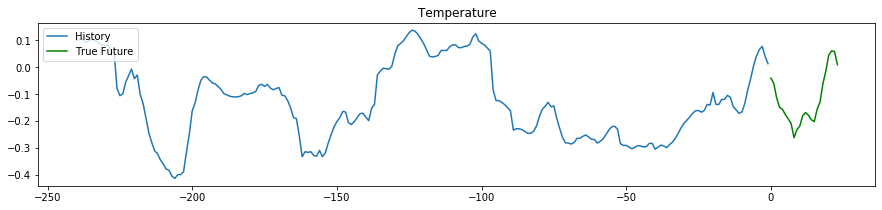

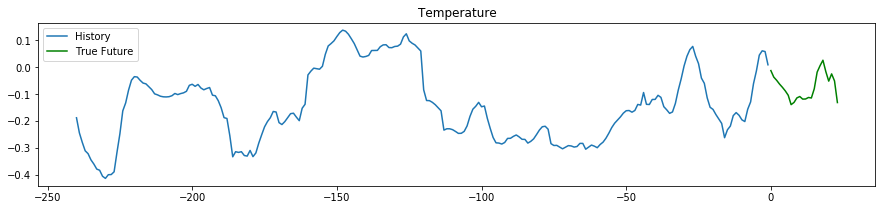

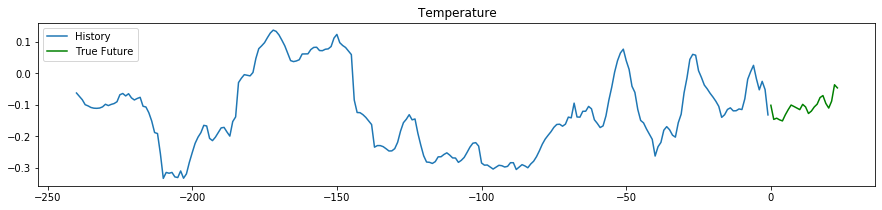

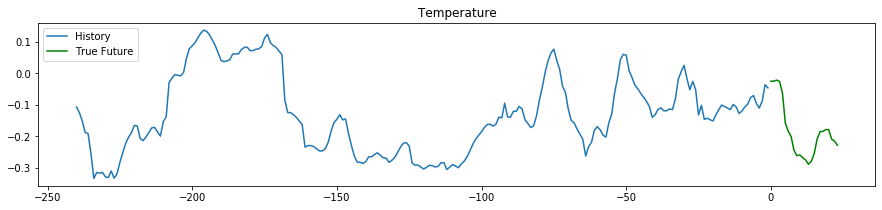

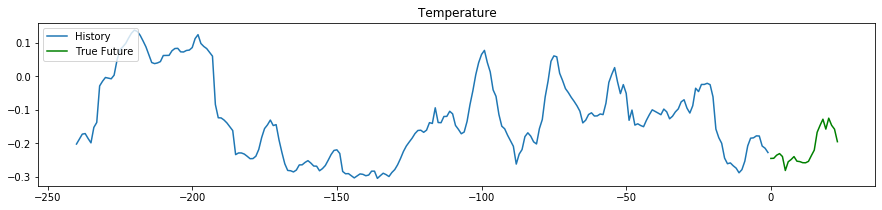

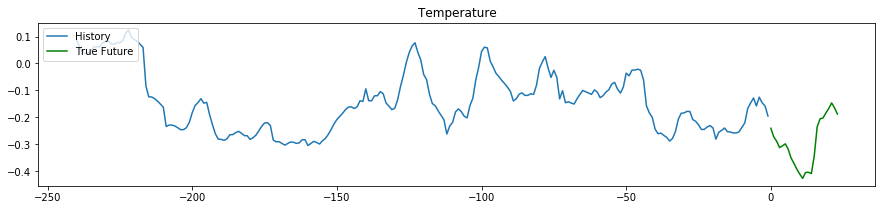

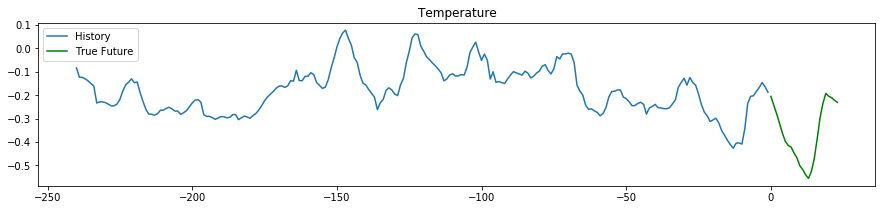

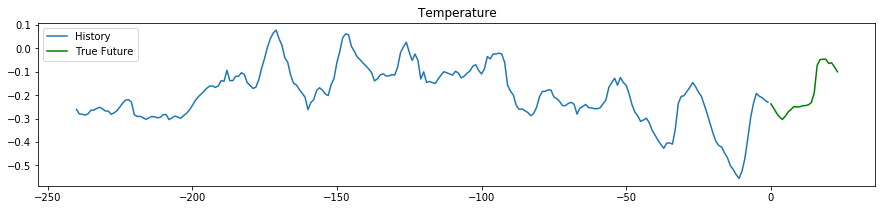

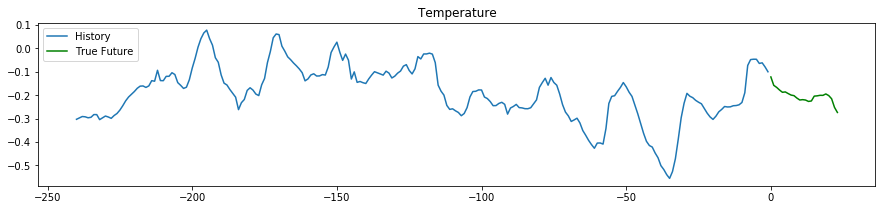

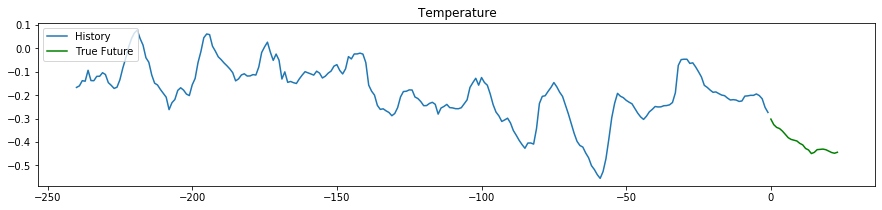

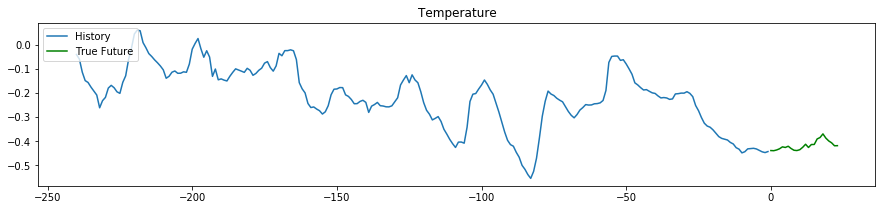

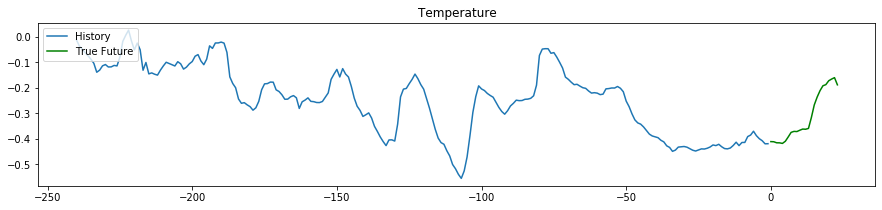

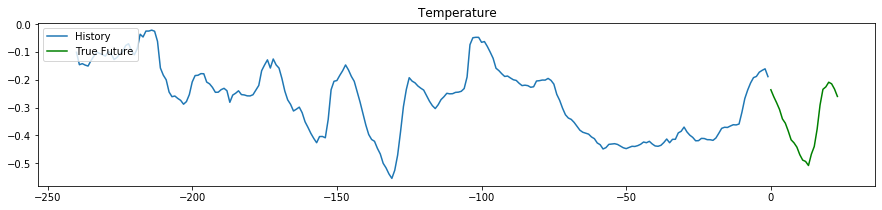

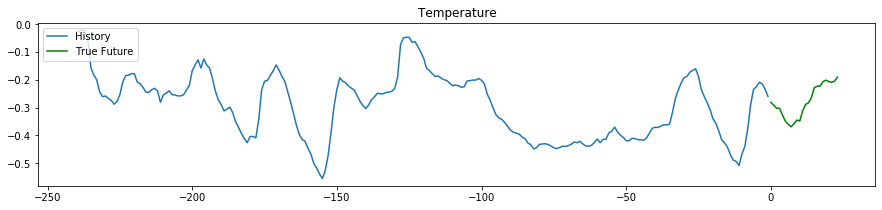

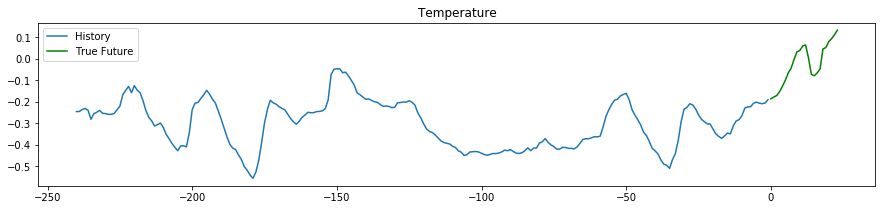

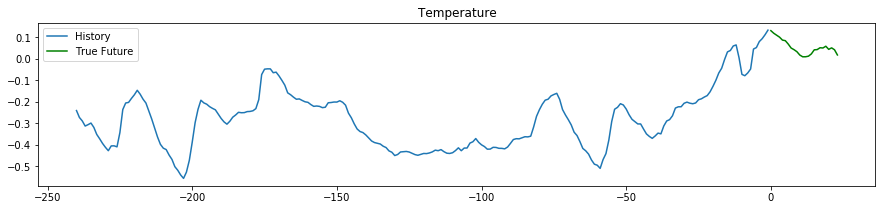

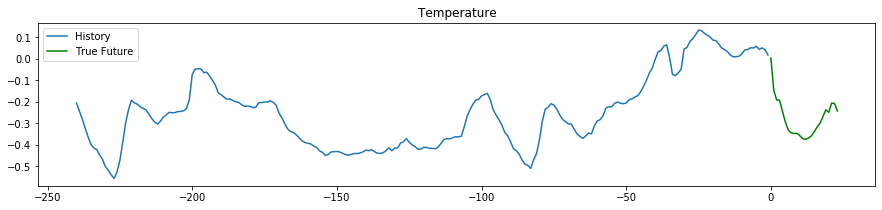

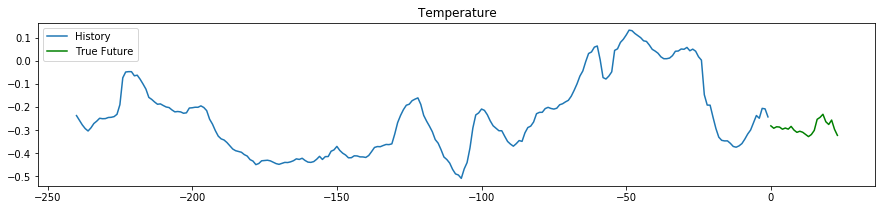

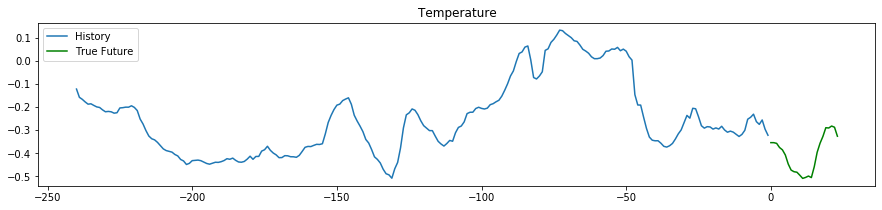

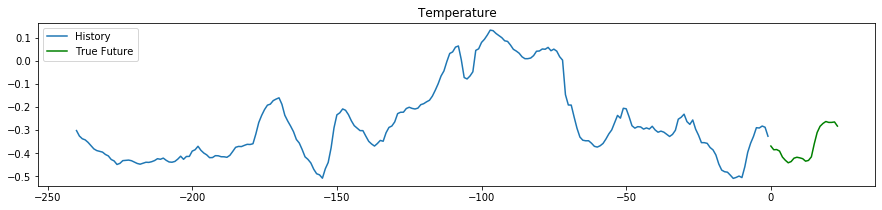

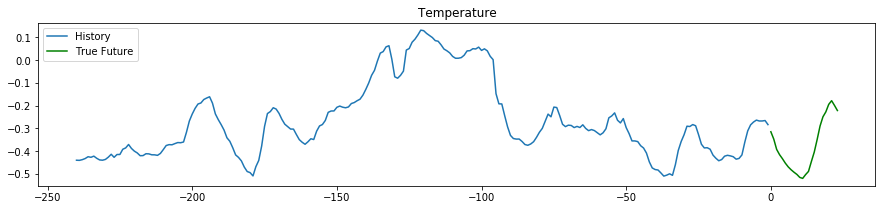

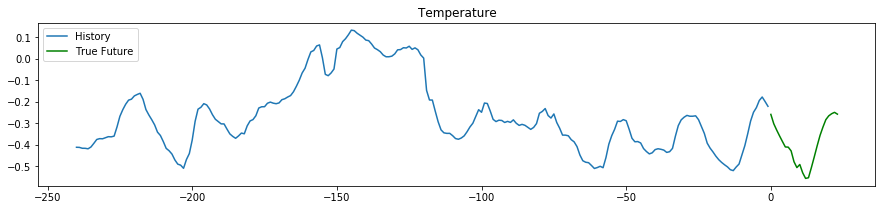

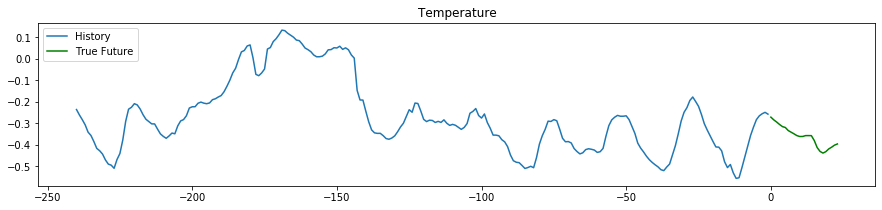

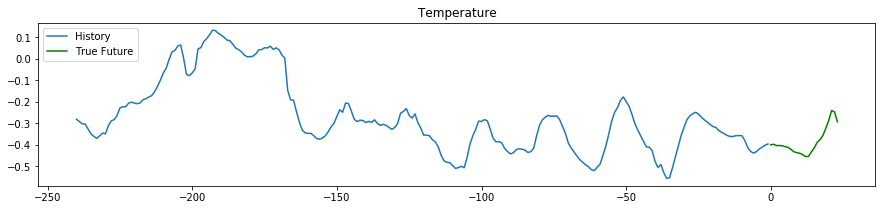

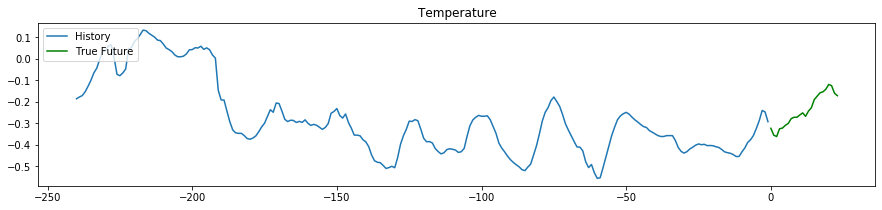

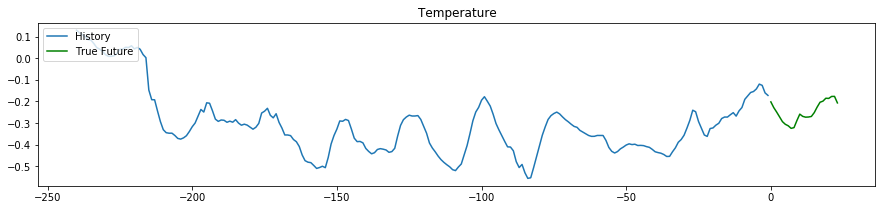

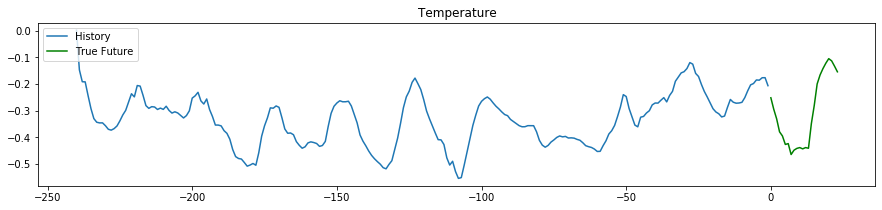

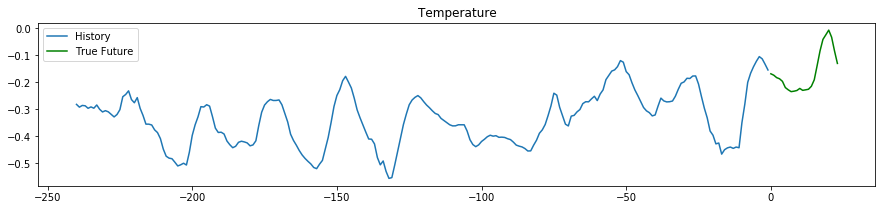

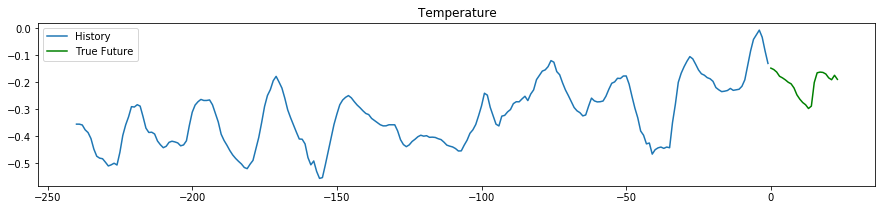

Input data shape (timesteps, features):  (240, 7)
Output data shape (timesteps, features):  (24, 1)


In [12]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)

  return time_steps

def plot_prediction(history, true_future, prediction):
  plt.figure(figsize=(15, 3))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.title('Temperature')
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'g', label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'r', label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

# Plot one batch
for x, y in val_data.take(1):
  for i in range(0, len(x)):
    plot_prediction(x[i], y[i], np.array([0]))

input_shape = x[i].shape
output_shape = y[i].shape

print('Input data shape (timesteps, features): ', input_shape)
print('Output data shape (timesteps, features): ', output_shape)

## Training

![alt text](https://raw.githubusercontent.com/KrzysztofV/colab-lstm-temperature-prediction/master/training.png)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 240, 112)          4032      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 240, 112)          62832     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 120, 224)          125664    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 60, 224)           251104    
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 256)           492544    
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 128)           197120    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)               

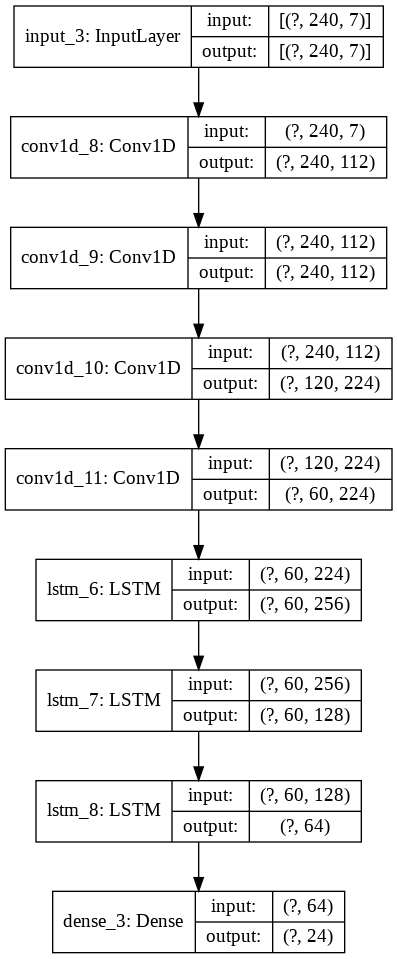

In [17]:
log_dir="logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

checkpoint_path = "logs/ckpt/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, period=1)

def learning_rate_scheduler(epoch):
  learning_rate = 0.0001
  if epoch >= 50:
    learning_rate = 0.00005

  return learning_rate
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

for x, y in val_data.take(1):
  x_vis = x
  y_vis = y
class on_epoch_end_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):  
    prediction = model.predict(x_vis)[-1] # last prediction at index 0
    plot_prediction(x_vis[-1], y_vis[-1], prediction) 

def build_model(input_shape, n_outputs):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*16, kernel_size=5, padding='same', activation='relu'))
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*16, kernel_size=5, padding='same', activation='relu'))
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*32, kernel_size=5, strides=2, padding='same', activation='relu'))
  model.add(tf.keras.layers.Conv1D(filters=input_shape[1]*32, kernel_size=5, strides=2, padding='same', activation='relu'))
  model.add(tf.keras.layers.LSTM(256, return_sequences=True))
  model.add(tf.keras.layers.LSTM(128, return_sequences=True))
  model.add(tf.keras.layers.LSTM(64))
  model.add(tf.keras.layers.Dense(24))
  optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)
  model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
  return model

model = build_model(input_shape, output_shape[0])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
%tensorboard --logdir "/logs/"  --port 6008

In [0]:
# Loads the weights
model.load_weights('logs/ckpt/cp-0091.ckpt')

In [0]:
! rm -r '/content/logs'

Train for 85 steps, validate for 10 steps
Epoch 1/100
84/85 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.0967
Epoch 00001: saving model to logs/ckpt/cp-0001.ckpt


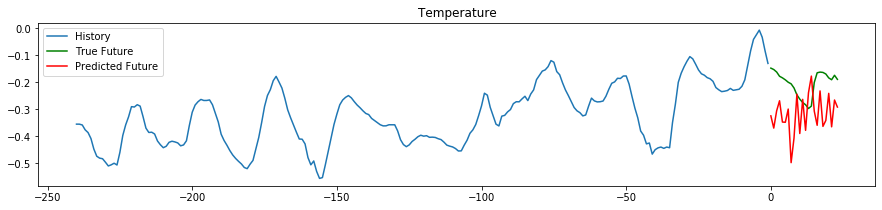

85/85 [==============================] - 36s 425ms/step - loss: 0.0652 - accuracy: 0.0979 - val_loss: 0.0405 - val_accuracy: 0.0033
Epoch 2/100
84/85 [============================>.] - ETA: 0s - loss: 0.0332 - accuracy: 0.1006
Epoch 00002: saving model to logs/ckpt/cp-0002.ckpt


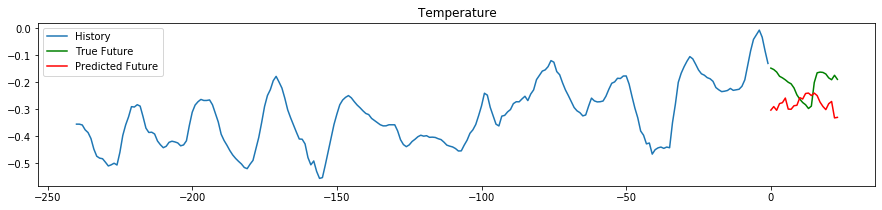

85/85 [==============================] - 30s 348ms/step - loss: 0.0331 - accuracy: 0.1006 - val_loss: 0.0324 - val_accuracy: 0.0000e+00
Epoch 3/100
84/85 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.1277
Epoch 00003: saving model to logs/ckpt/cp-0003.ckpt


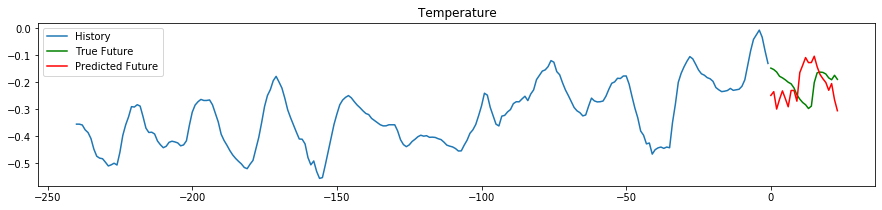

85/85 [==============================] - 28s 330ms/step - loss: 0.0290 - accuracy: 0.1266 - val_loss: 0.0315 - val_accuracy: 0.0067
Epoch 4/100
84/85 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.1118
Epoch 00004: saving model to logs/ckpt/cp-0004.ckpt


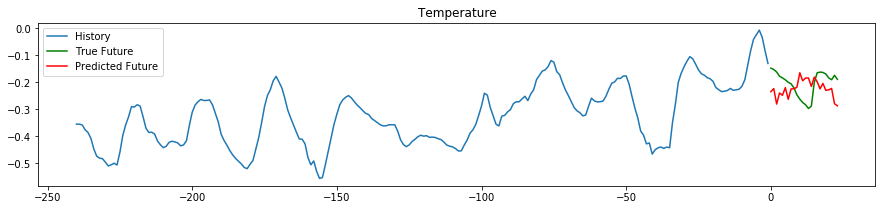

85/85 [==============================] - 30s 350ms/step - loss: 0.0269 - accuracy: 0.1116 - val_loss: 0.0281 - val_accuracy: 0.0100
Epoch 5/100
84/85 [============================>.] - ETA: 0s - loss: 0.0257 - accuracy: 0.1181
Epoch 00005: saving model to logs/ckpt/cp-0005.ckpt


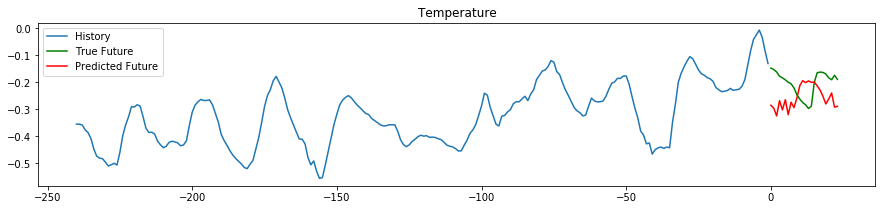

85/85 [==============================] - 29s 346ms/step - loss: 0.0259 - accuracy: 0.1167 - val_loss: 0.0296 - val_accuracy: 0.0100
Epoch 6/100
84/85 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 0.1385
Epoch 00006: saving model to logs/ckpt/cp-0006.ckpt


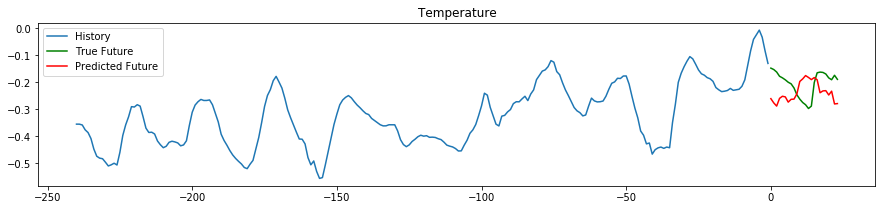

85/85 [==============================] - 29s 337ms/step - loss: 0.0251 - accuracy: 0.1388 - val_loss: 0.0259 - val_accuracy: 0.0100
Epoch 7/100
84/85 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.1300
Epoch 00007: saving model to logs/ckpt/cp-0007.ckpt


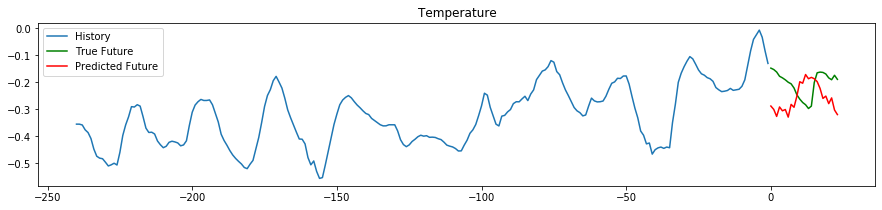

85/85 [==============================] - 29s 343ms/step - loss: 0.0229 - accuracy: 0.1300 - val_loss: 0.0279 - val_accuracy: 0.0067
Epoch 8/100
84/85 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.1484
Epoch 00008: saving model to logs/ckpt/cp-0008.ckpt


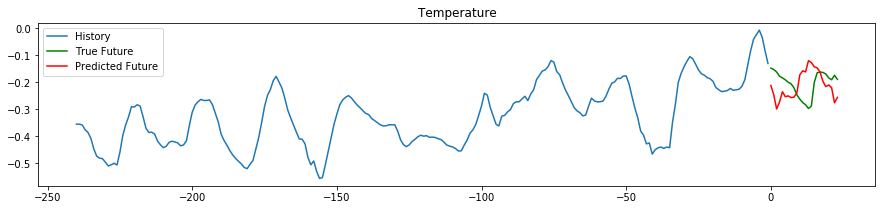

85/85 [==============================] - 30s 349ms/step - loss: 0.0229 - accuracy: 0.1486 - val_loss: 0.0246 - val_accuracy: 0.0100
Epoch 9/100
84/85 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.1340
Epoch 00009: saving model to logs/ckpt/cp-0009.ckpt


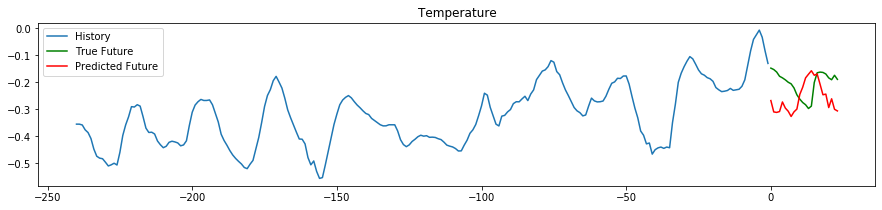

85/85 [==============================] - 29s 342ms/step - loss: 0.0214 - accuracy: 0.1336 - val_loss: 0.0273 - val_accuracy: 0.0067
Epoch 10/100
84/85 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.1134
Epoch 00010: saving model to logs/ckpt/cp-0010.ckpt


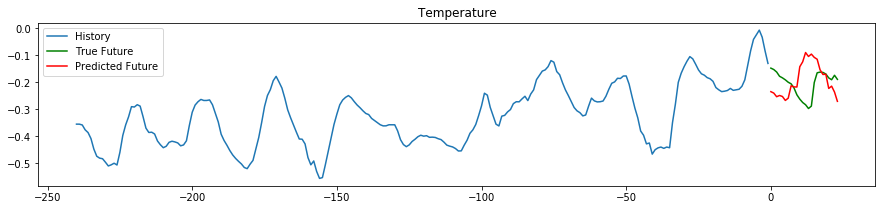

85/85 [==============================] - 29s 340ms/step - loss: 0.0225 - accuracy: 0.1148 - val_loss: 0.0269 - val_accuracy: 0.0033
Epoch 11/100
84/85 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.1340
Epoch 00011: saving model to logs/ckpt/cp-0011.ckpt


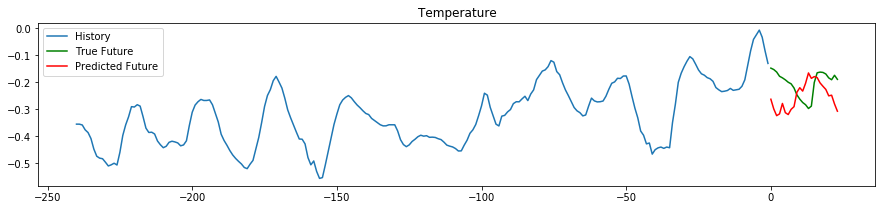

85/85 [==============================] - 29s 341ms/step - loss: 0.0205 - accuracy: 0.1344 - val_loss: 0.0275 - val_accuracy: 0.0000e+00
Epoch 12/100
84/85 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.1289
Epoch 00012: saving model to logs/ckpt/cp-0012.ckpt


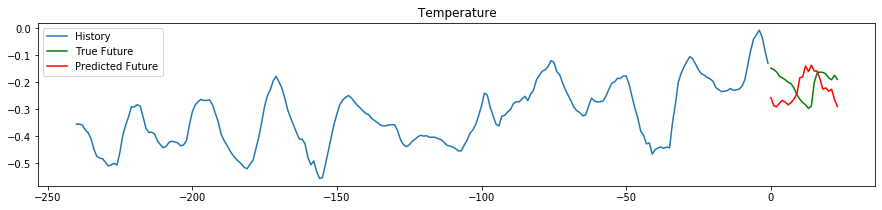

85/85 [==============================] - 29s 346ms/step - loss: 0.0207 - accuracy: 0.1301 - val_loss: 0.0258 - val_accuracy: 0.0000e+00
Epoch 13/100
84/85 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.1265
Epoch 00013: saving model to logs/ckpt/cp-0013.ckpt


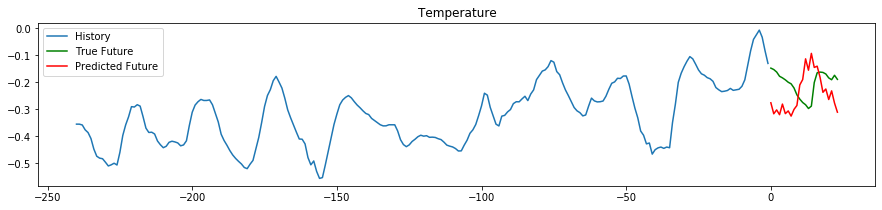

85/85 [==============================] - 30s 350ms/step - loss: 0.0195 - accuracy: 0.1270 - val_loss: 0.0296 - val_accuracy: 0.0033
Epoch 14/100
29/85 [=========>....................] - ETA: 17s - loss: 0.0210 - accuracy: 0.1149

In [0]:
epochs = 100
history = model.fit(train_data, 
                    epochs=epochs, 
                    initial_epoch = 0,
                    steps_per_epoch=int(x_train.shape[0]/batch_size), 
                    validation_data=val_data, 
                    validation_steps=int(x_val.shape[0]/batch_size), 
                    validation_freq = 1,
                    callbacks=[tensorboard_callback, checkpoint_callback, learning_rate_callback, on_epoch_end_callback()])

## Evaluation

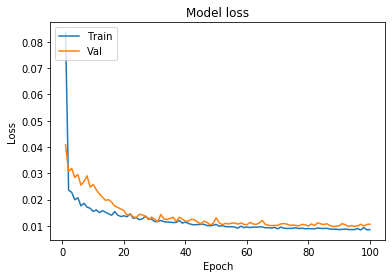

In [81]:
def plot_learningCurve(history, epochs):
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, epochs)

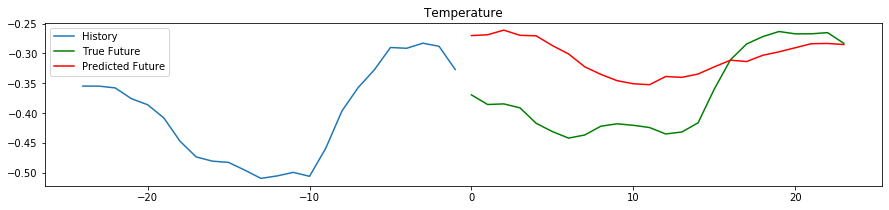

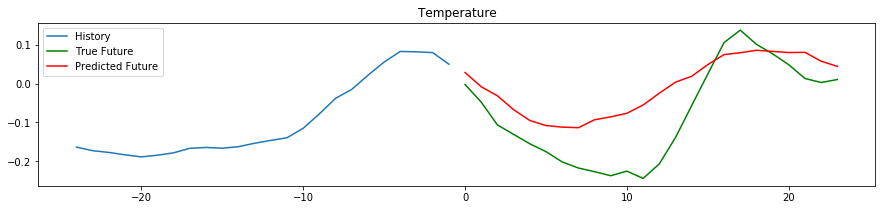

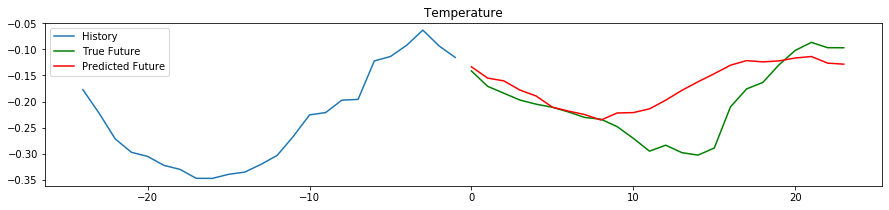

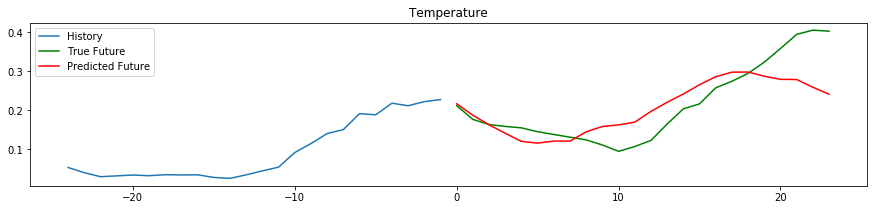

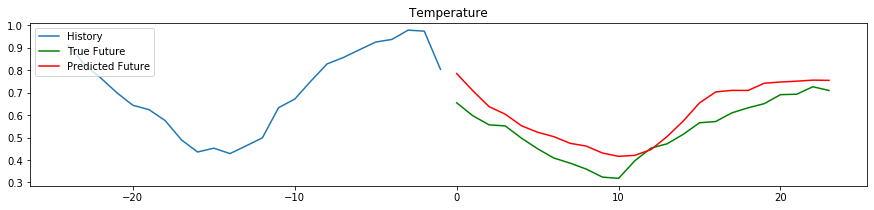

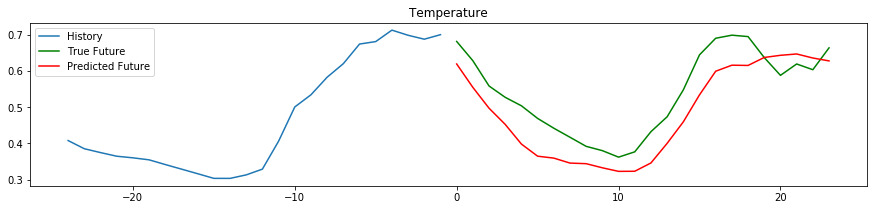

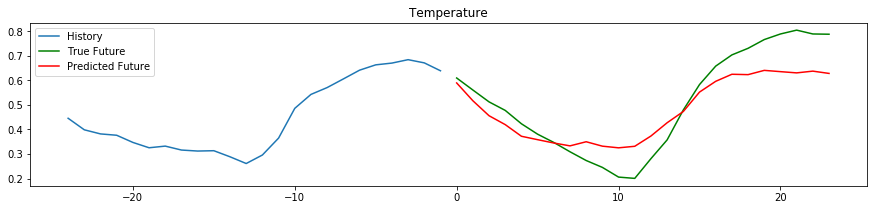

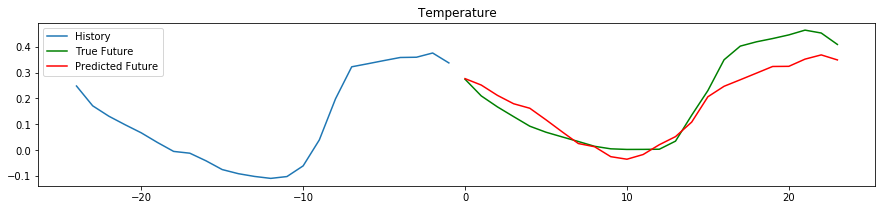

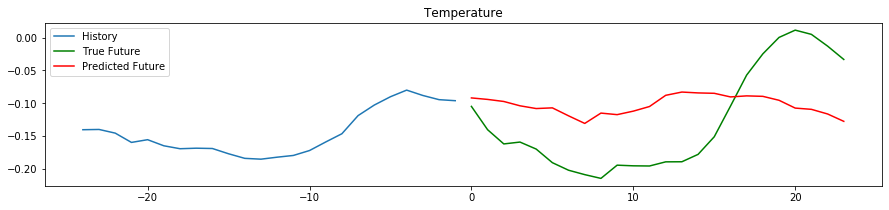

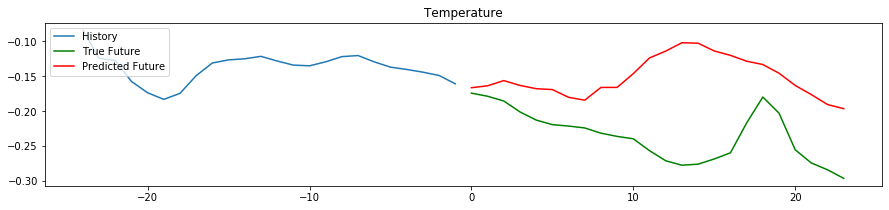

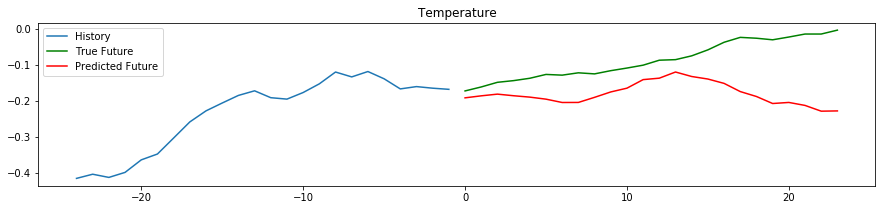

In [82]:
# Comparing prediction with true data - all validation batches
for x, y in val_data.take(int(x_val.shape[0]/batch_size)):
  prediction = model.predict(x)[-1]
  plot_prediction(x[-1], y[-1], prediction)

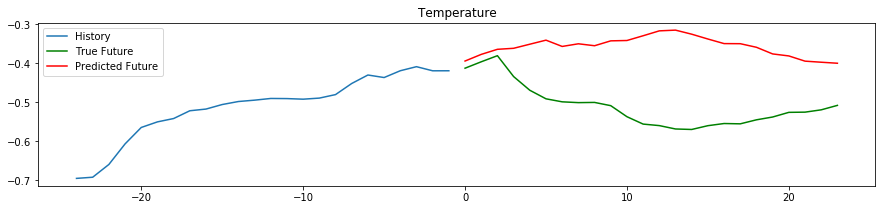

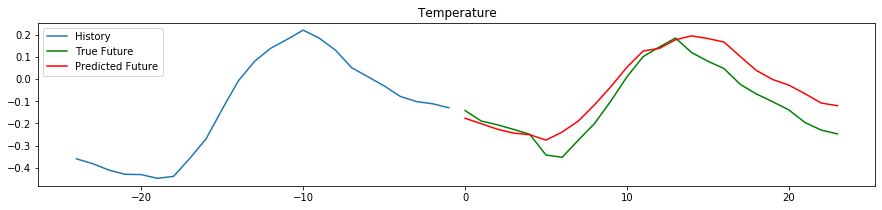

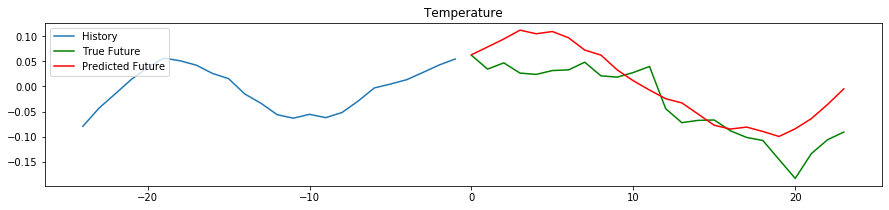

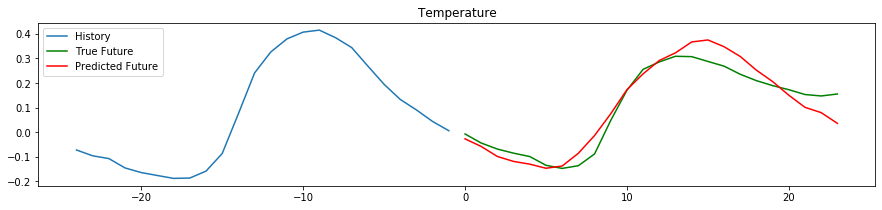

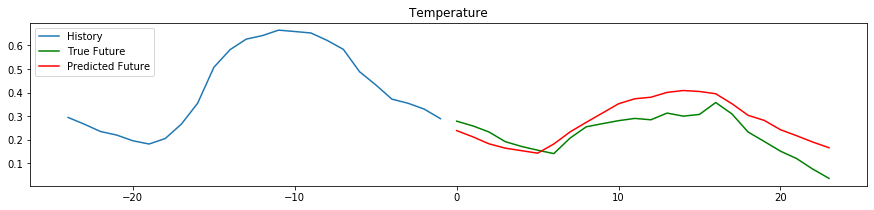

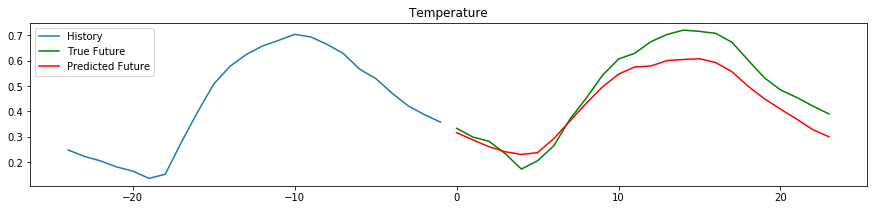

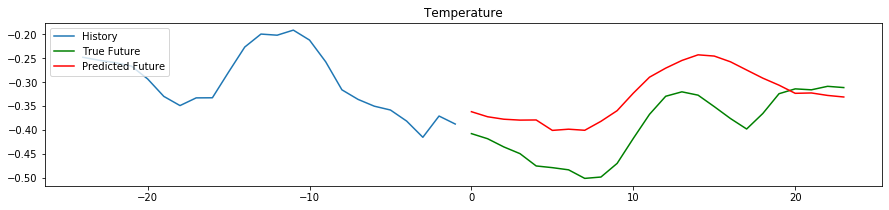

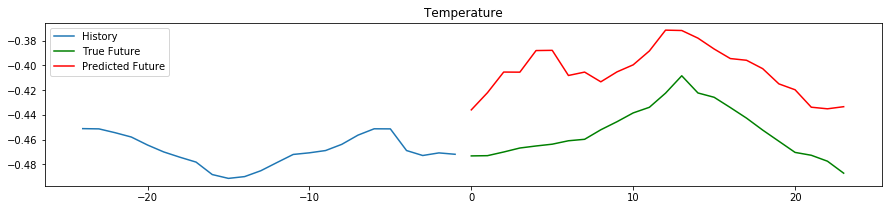

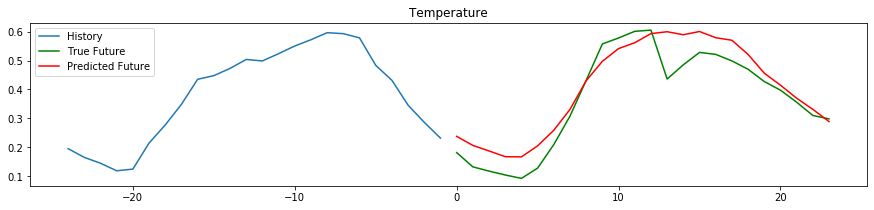

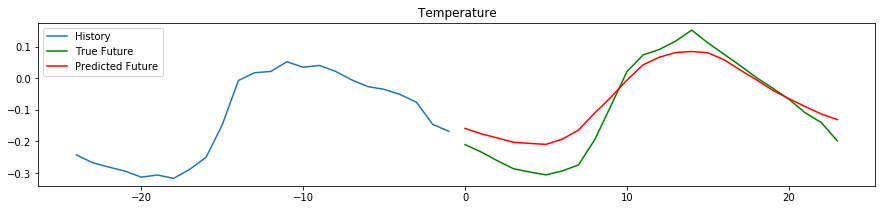

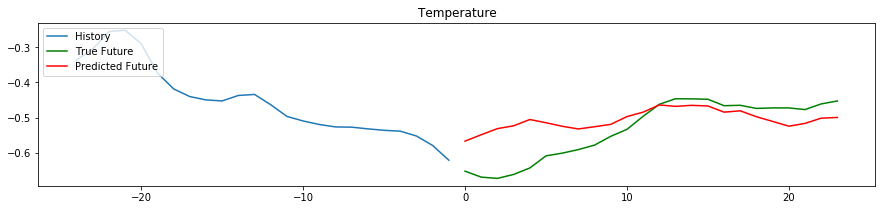

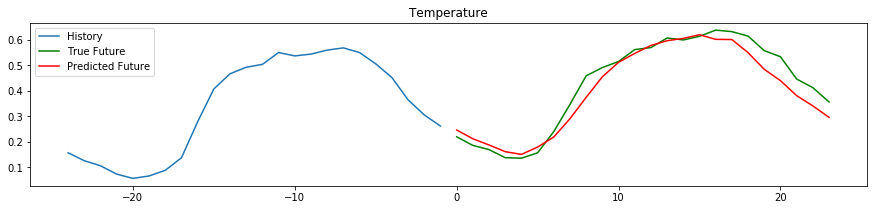

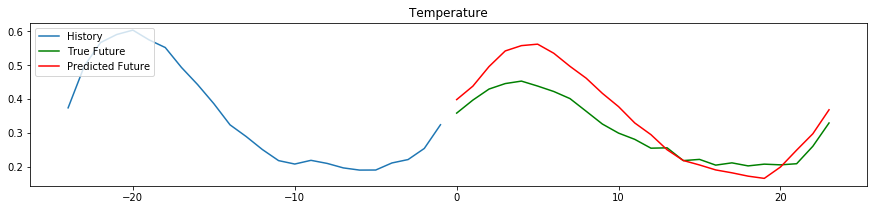

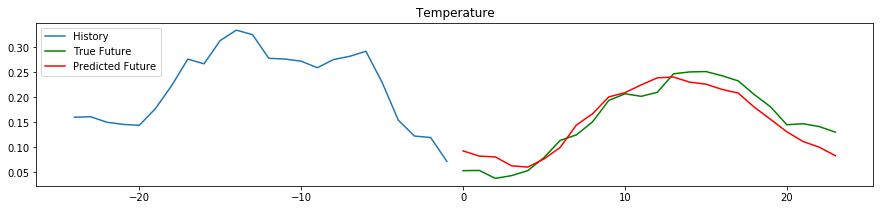

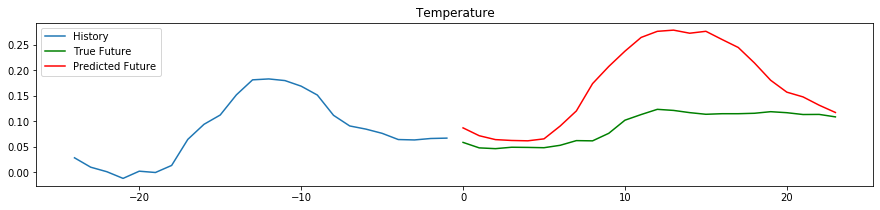

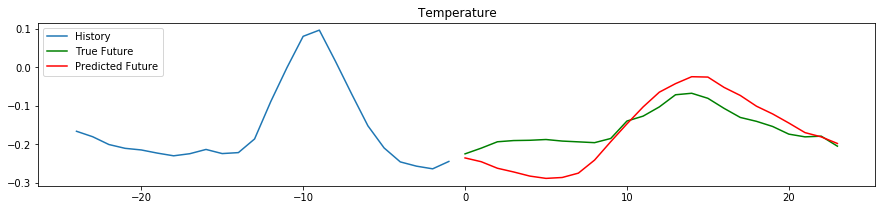

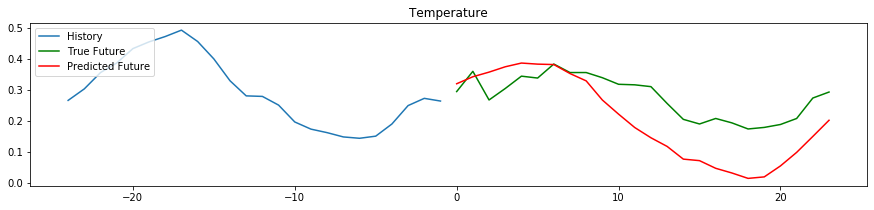

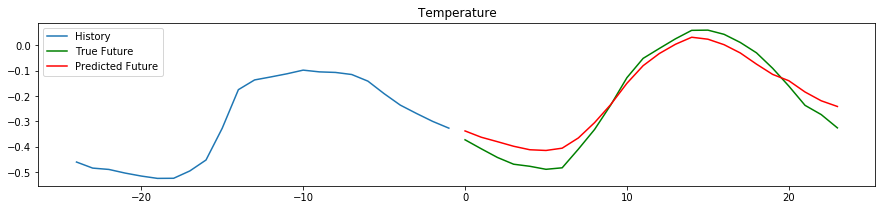

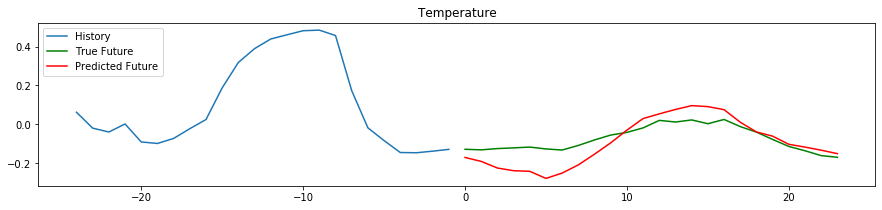

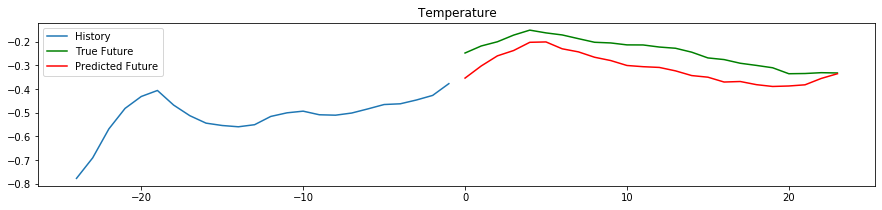

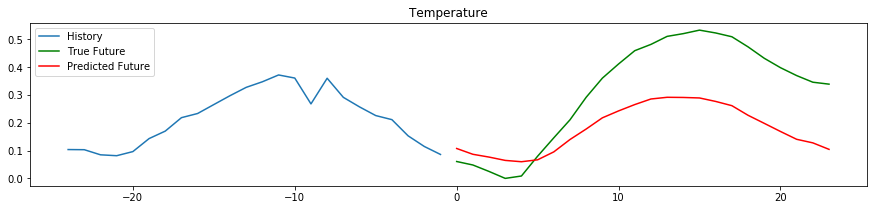

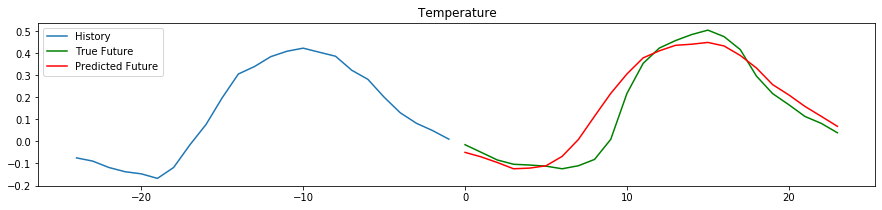

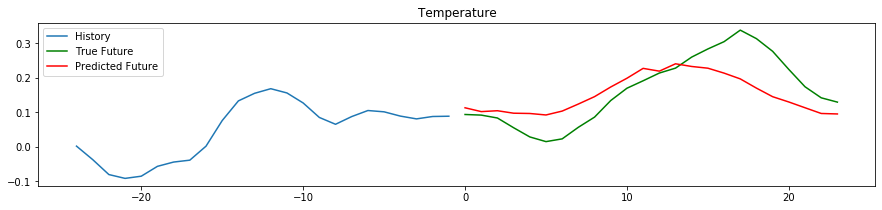

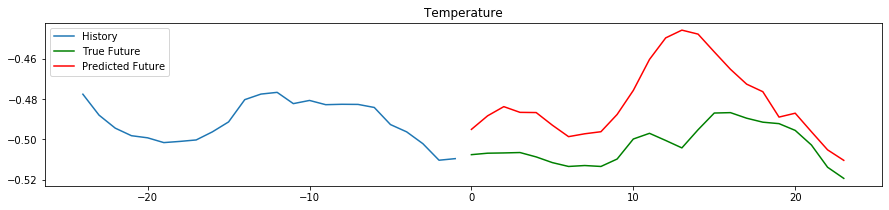

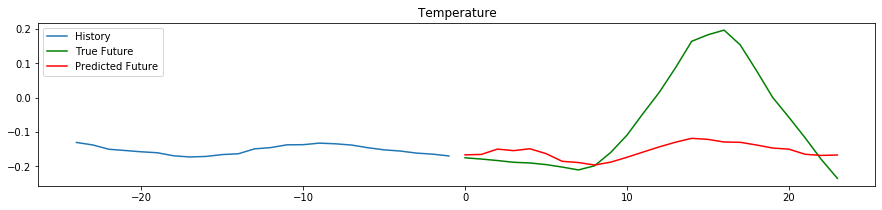

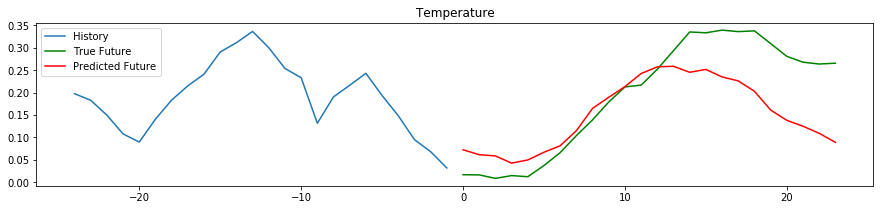

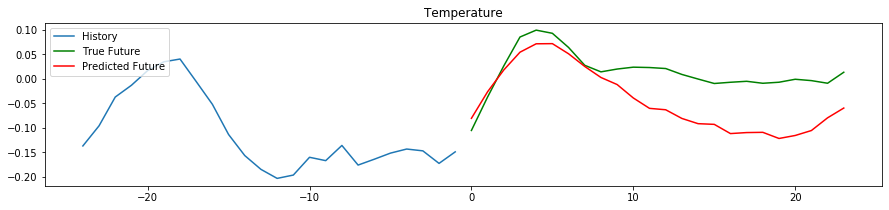

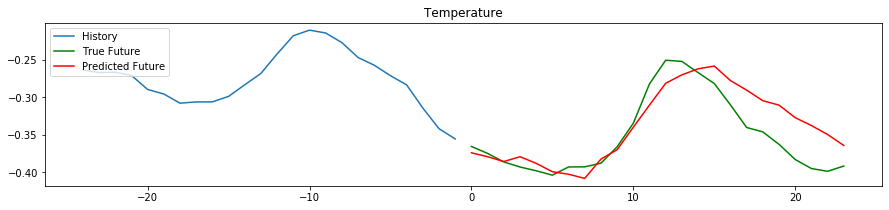

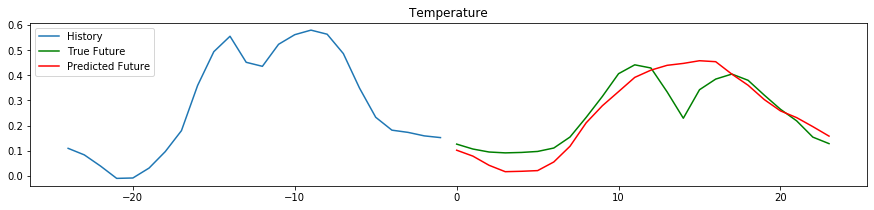

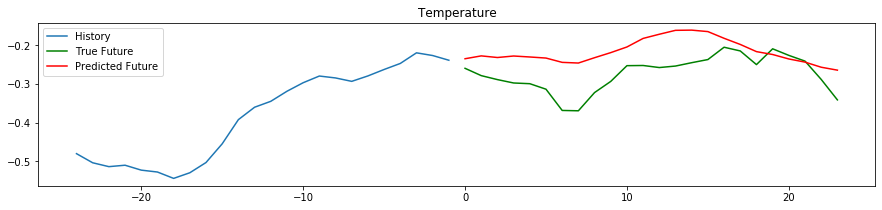

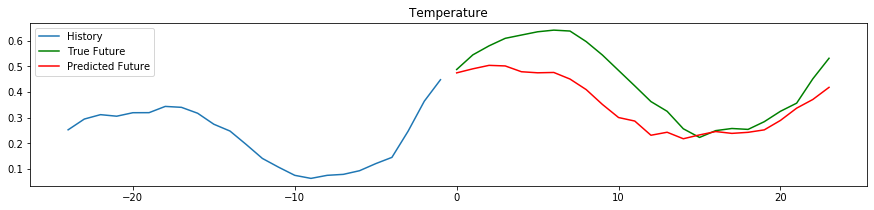

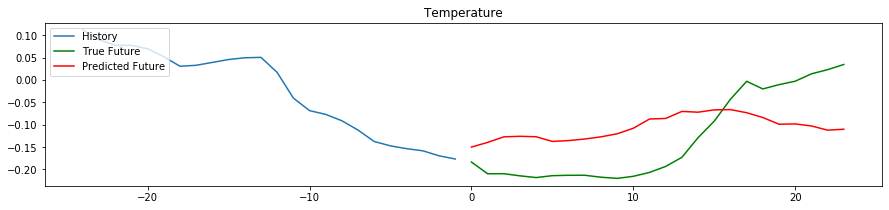

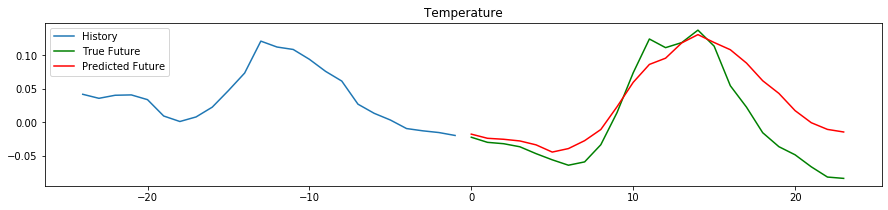

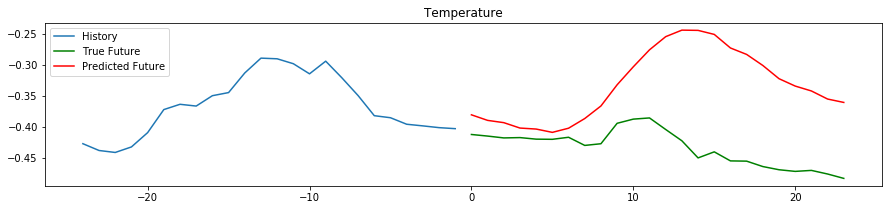

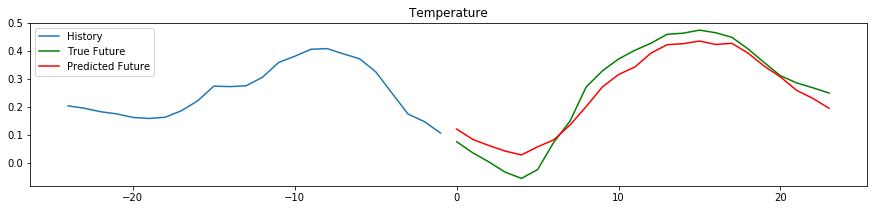

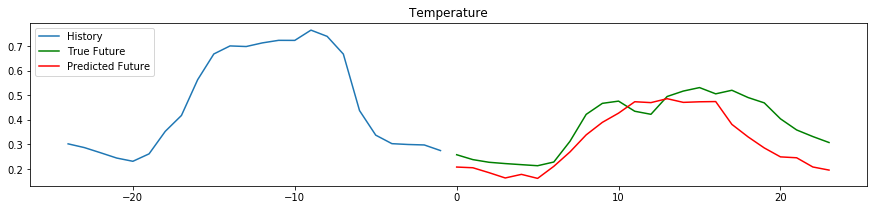

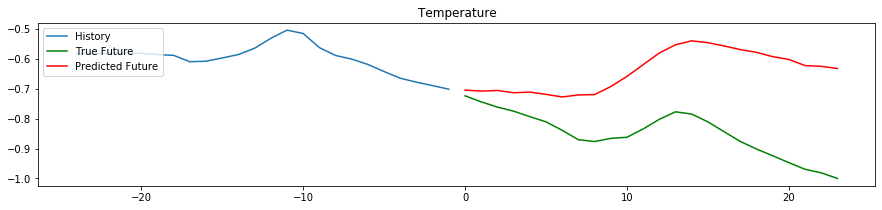

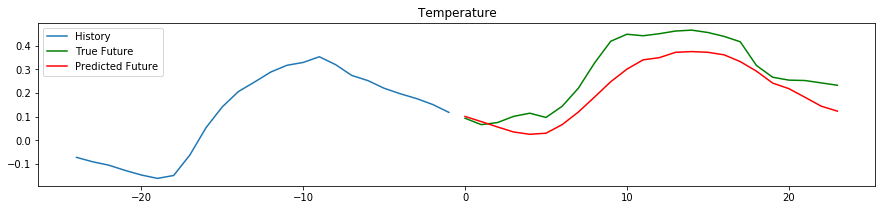

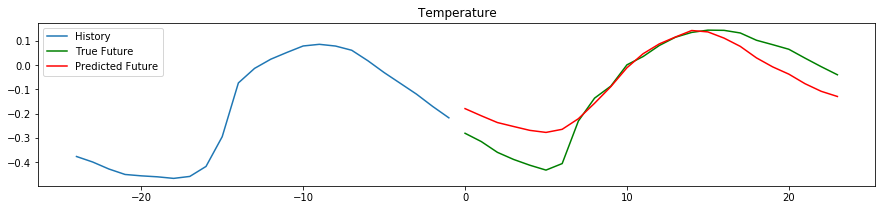

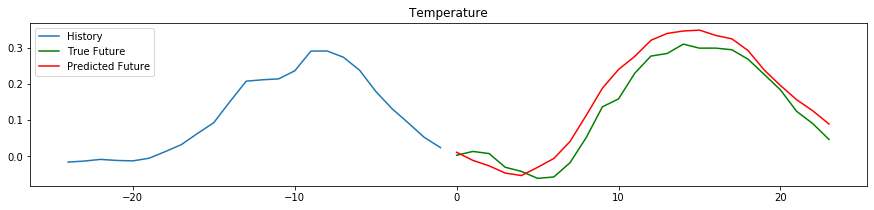

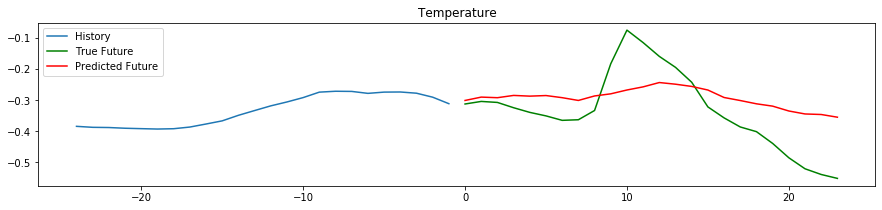

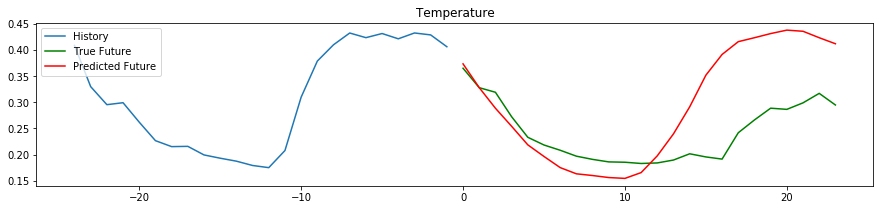

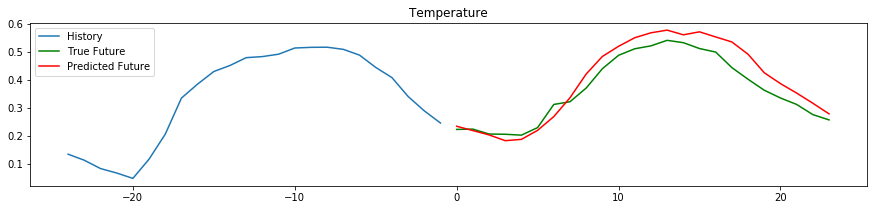

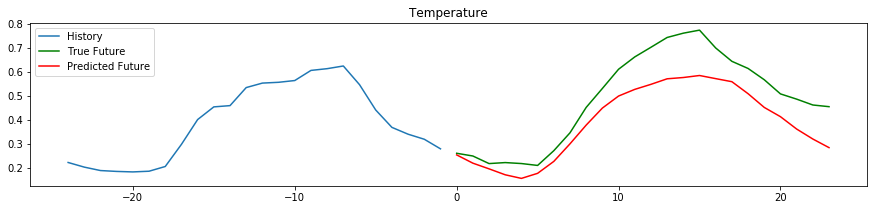

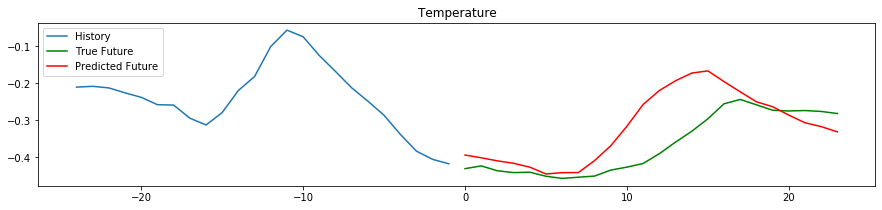

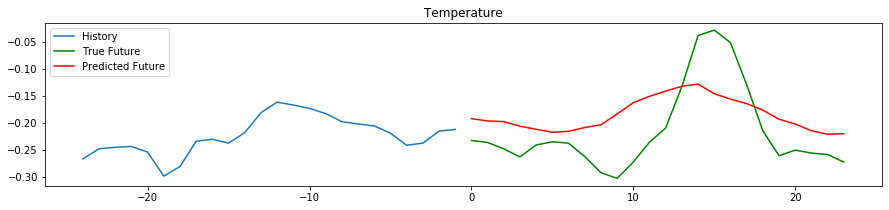

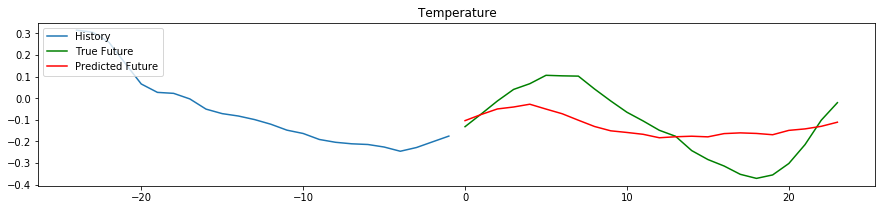

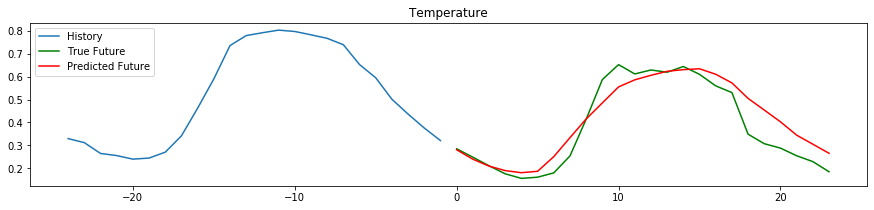

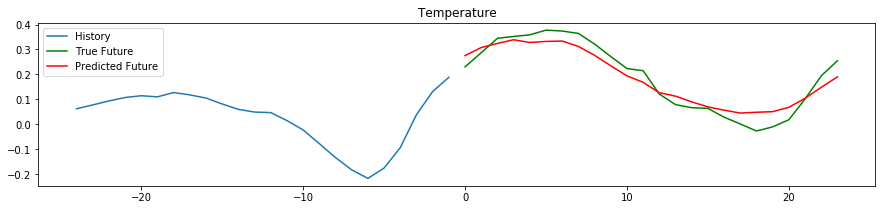

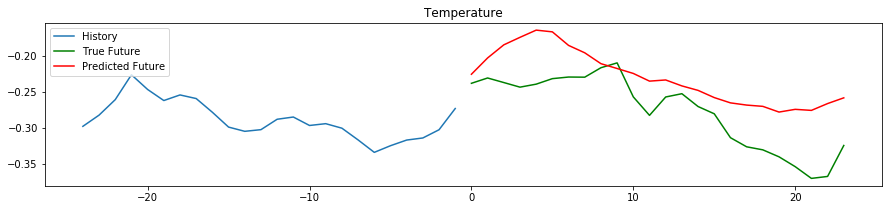

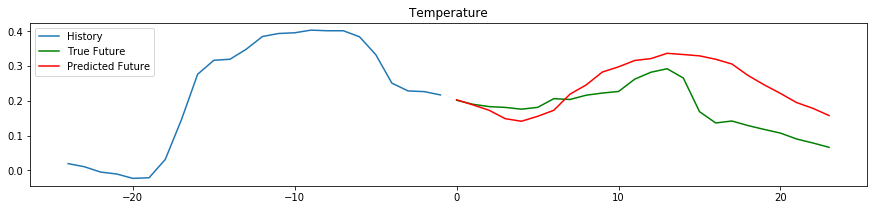

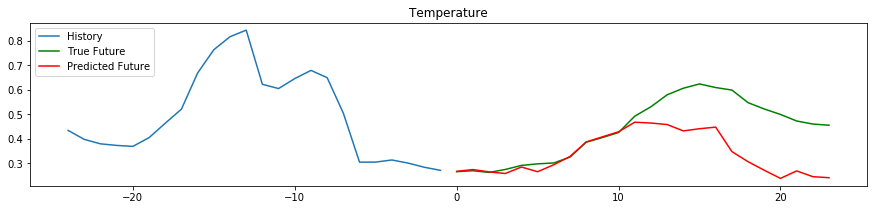

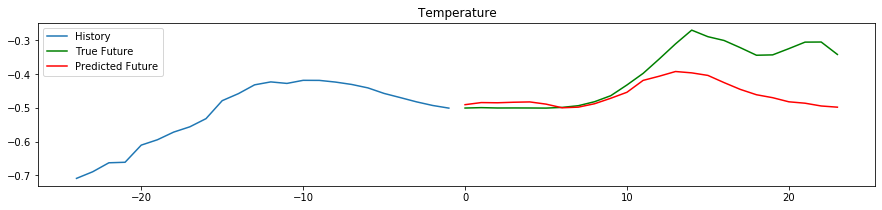

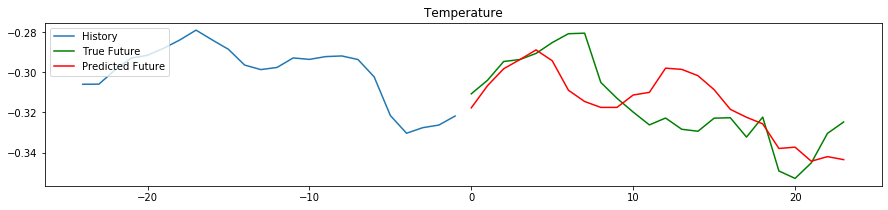

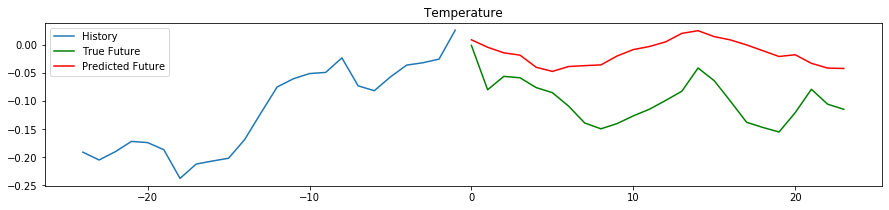

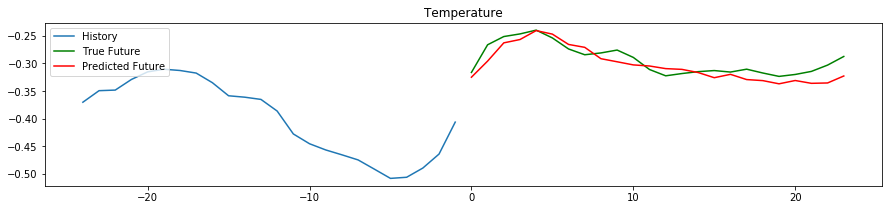

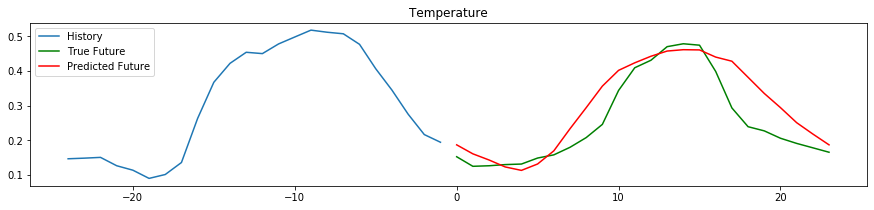

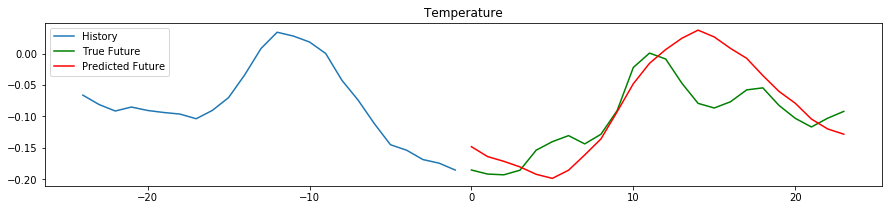

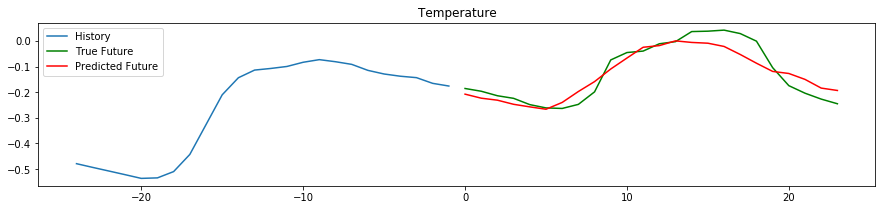

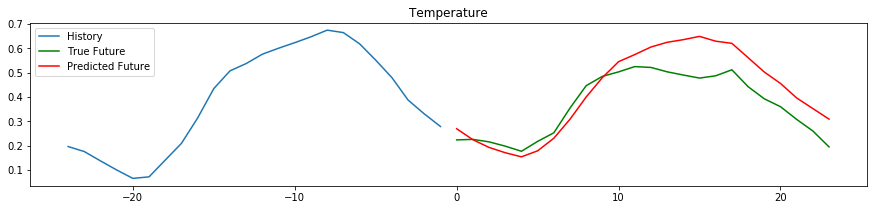

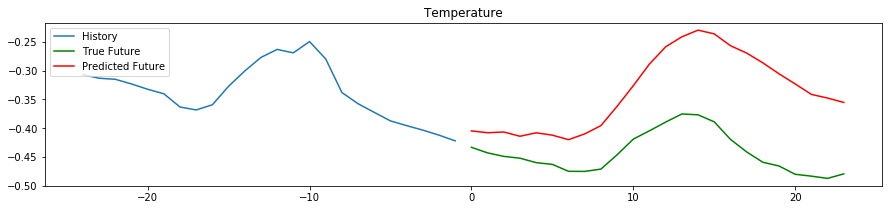

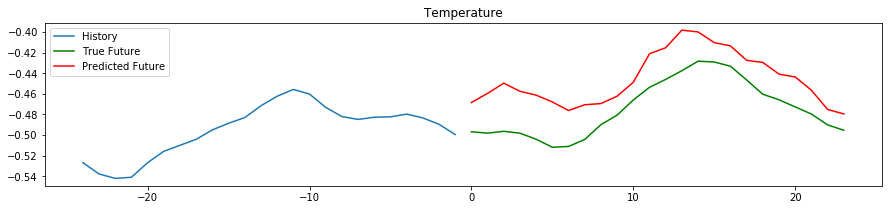

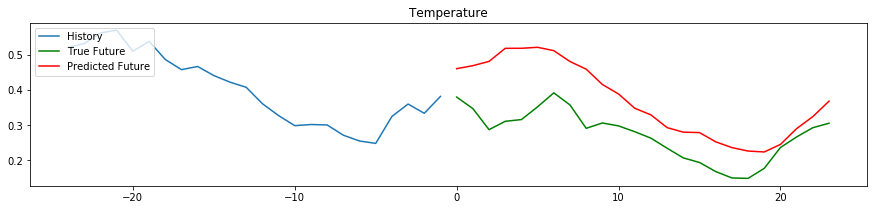

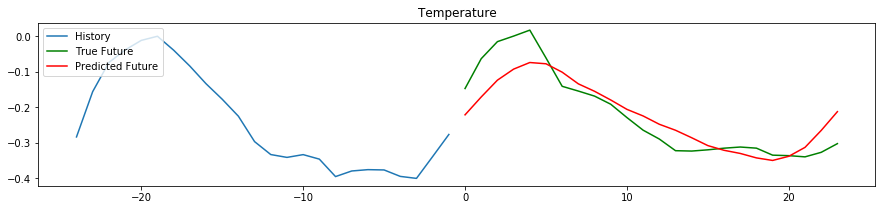

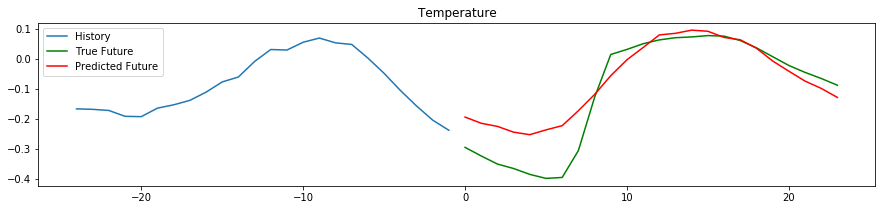

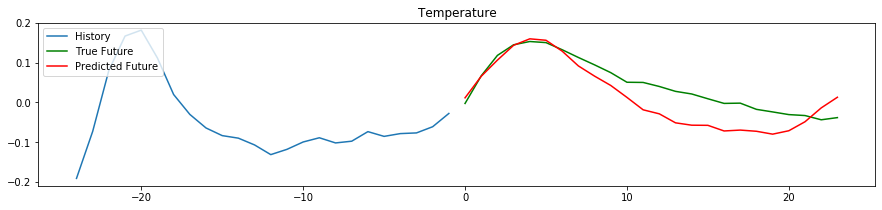

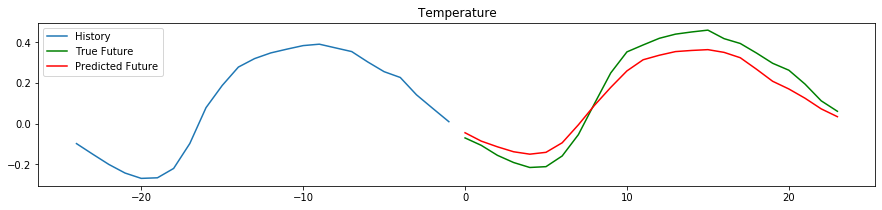

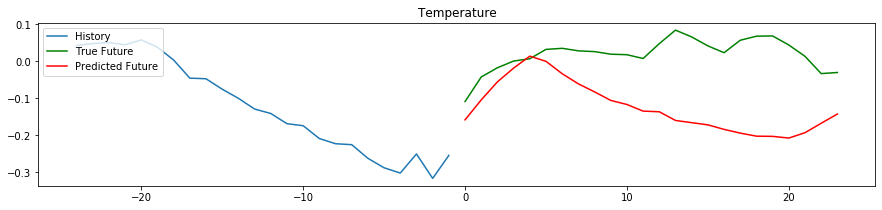

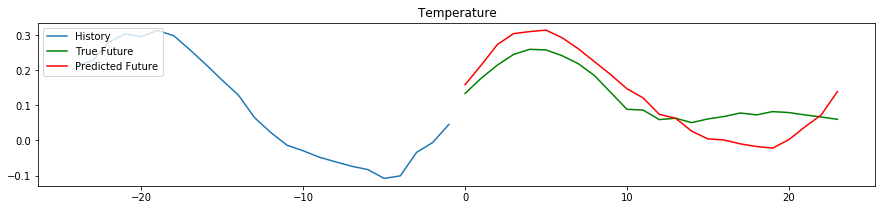

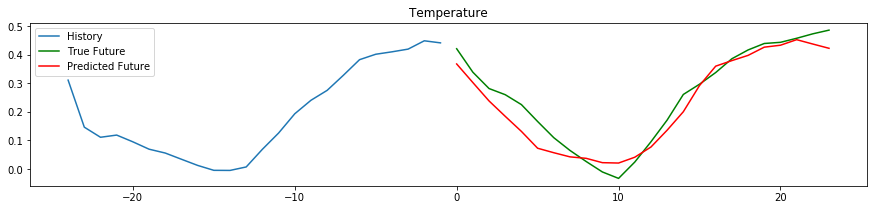

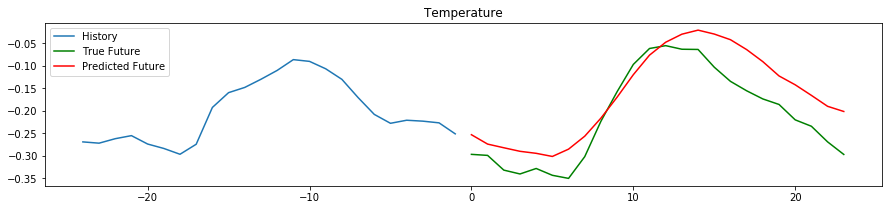

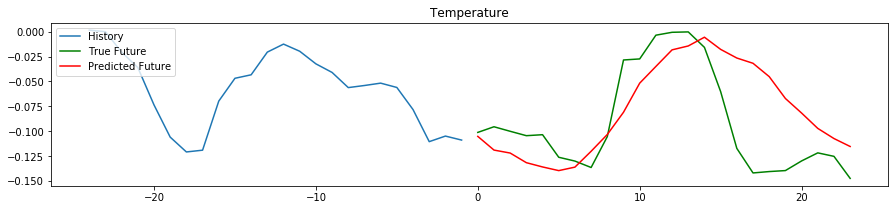

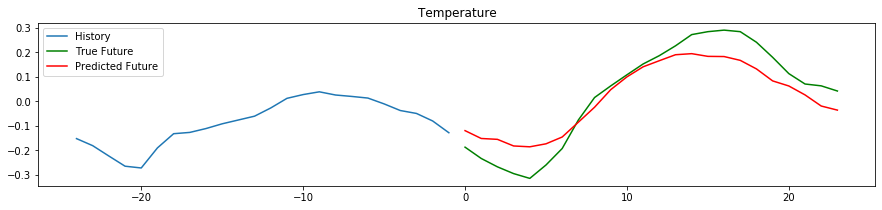

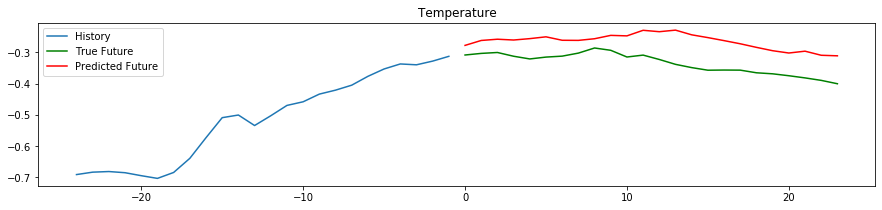

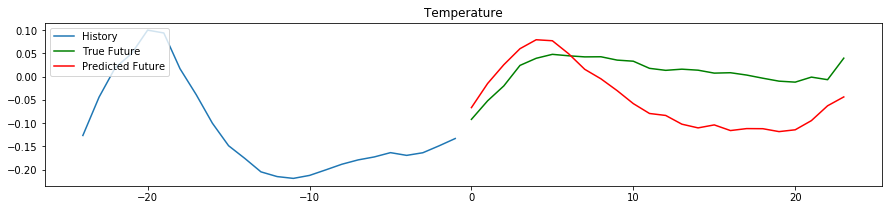

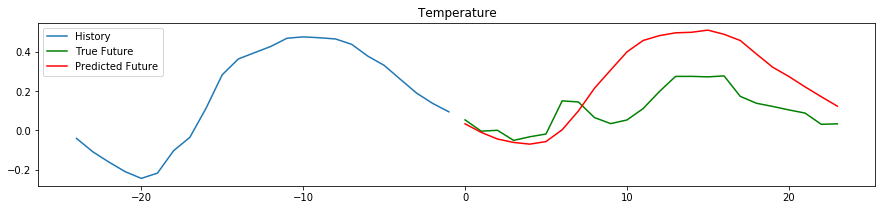

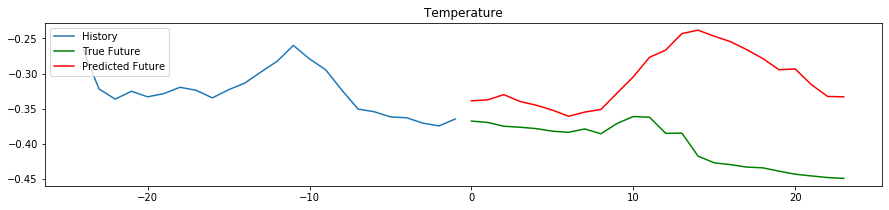

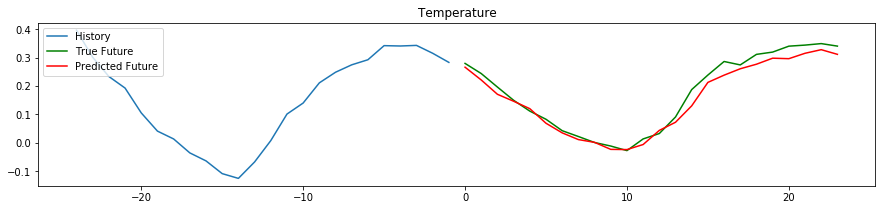

KeyboardInterrupt: ignored

In [83]:
# Comparing prediction with true data - all train batches
for x, y in train_data.take(int(x_train.shape[0]/batch_size)):
  prediction = model.predict(x)[-1]
  plot_prediction(x[-1], y[-1], prediction)